
<a id='parallel'></a>
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# NumPy (phase 2) vs Numba (phase 3) vs JAX (phase 4)

## Prepared for the IMF October 2023

### John Stachurski

[NumPy](https://numpy.org/) is a legacy Python library using pre-compiled code for array operations

[Numba](https://numba.pydata.org/) is a modern JIT compiler built on LLVM

[JAX](https://github.com/google/jax) is an "open source" Google project that combines 

* NumPy style array processing
* a highly efficient JIT-compiler for array operations
* automatic differentiation
* the ability to specialize JIT-compiled code for CPUs / GPUs / TPUs

In general

* Numba is better for purely sequential single threaded tasks
* JAX is better for parallelizable tasks / array processing
* NumPy is old-school but still convenient

JAX almost always dominates NumPy in performance.

## How to run this lecture

You can run this lecture on your laptop / desktop CPU if you install Anaconda Python + JAX for the CPU.  Uncomment what you need:

In [29]:
#!pip install jax"[CPU]"

**However**, the real benefit of JAX comes with GPU access.

The easiest way to get this is to 

- open this notebook on Google Colab (GitHub -> jstac -> minnesota_2023)
- select "Notebook settings" and then add a GPU

We begin by importing NumPy, Numba, JAX and a plotting library:

In [30]:
import numpy as np
from numpy.random import randn
import numba 
from numba import njit, vectorize, float64
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

Let's see the specs of our machine.

In [31]:
!lscpu -e

CPU NODE SOCKET CORE L1d:L1i:L2:L3 ONLINE    MAXMHZ   MINMHZ      MHZ
  0    0      0    0 0:0:0:0          yes 5000.0000 800.0000 4799.849
  1    0      0    1 1:1:1:0          yes 5000.0000 800.0000 2400.000
  2    0      0    2 2:2:2:0          yes 5000.0000 800.0000 2400.000
  3    0      0    3 3:3:3:0          yes 5000.0000 800.0000 2400.000
  4    0      0    4 4:4:4:0          yes 5000.0000 800.0000 2400.000
  5    0      0    5 5:5:5:0          yes 5000.0000 800.0000 3460.604
  6    0      0    6 6:6:6:0          yes 5000.0000 800.0000 2400.000
  7    0      0    7 7:7:7:0          yes 5000.0000 800.0000 4764.491
  8    0      0    0 0:0:0:0          yes 5000.0000 800.0000 2400.000
  9    0      0    1 1:1:1:0          yes 5000.0000 800.0000 2400.000
 10    0      0    2 2:2:2:0          yes 5000.0000 800.0000 2400.000
 11    0      0    3 3:3:3:0          yes 5000.0000 800.0000 2400.000
 12    0      0    4 4:4:4:0          yes 5000.0000 800.0000 4791.905
 13    0      0    5

## Multivariate Optimization

The problem is to maximize the function 

$$ f(x, y) = \frac{\cos \left(x^2 + y^2 \right)}{1 + x^2 + y^2} + 1$$

using brute force --- searching over a grid of $(x, y)$ pairs.

In [32]:
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1

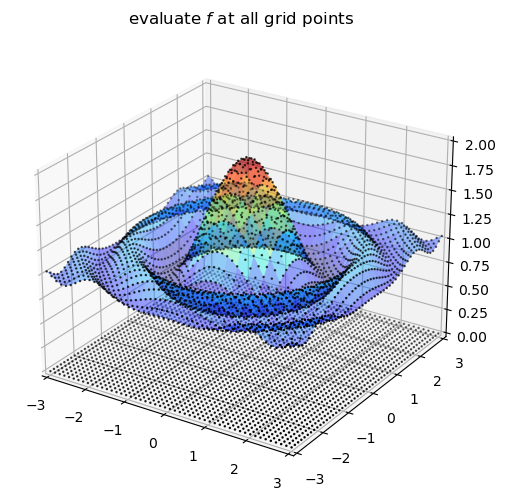

In [33]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

gridsize = 50
gmin, gmax = -3, 3
xgrid = np.linspace(gmin, gmax, gridsize)
ygrid = xgrid
x, y = np.meshgrid(xgrid, ygrid)

# === plot value function === #
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,
                y,
                f(x, y),
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.4,
                linewidth=0.05)

ax.set_title("evaluate $f$ at all grid points")
ax.scatter(x, y, c='k', s=0.6)

ax.scatter(x, y, f(x, y), c='k', s=0.6)

ax.view_init(25, -57)
ax.set_zlim(-0, 2.0)
ax.set_xlim(gmin, gmax)
ax.set_ylim(gmin, gmax)

plt.show()

For the grid size we set 

In [34]:
n = 12_000

Let's try a few different methods to make it fast.

### NumPy (MATLAB work-alike)

In [35]:
grid = np.linspace(-3, 3, num=n)

x, y = np.meshgrid(grid, grid)

In [36]:
%time out = np.max(f(x, y))

CPU times: user 2.03 s, sys: 318 ms, total: 2.35 s
Wall time: 2.35 s


In [37]:
%time out = np.max(f(x, y))

CPU times: user 2.01 s, sys: 381 ms, total: 2.39 s
Wall time: 2.39 s


### Numba JIT-compiled code with loops


A jitted version

In [38]:
@numba.njit 
def compute_max():
    m = -np.inf
    for x in grid:
        for y in grid:
            z = np.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1
            if z > m:
                m = z
    return m

First run includes compile time:

In [39]:
%time out = compute_max()

CPU times: user 1.39 s, sys: 0 ns, total: 1.39 s
Wall time: 1.39 s


Second run is without:

In [40]:
%time out = compute_max()

CPU times: user 1.32 s, sys: 5.31 ms, total: 1.33 s
Wall time: 1.32 s


Why is that faster than NumPy's highly optimized pre-compiled code???

### JAX on the CPU / GPU

Now let's try JAX.

This code will work well if you have a GPU and JAX configured to use it.

Let's see what we have available.

In [41]:
!nvidia-smi

Tue Oct  3 22:11:20 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080         On | 00000000:0A:00.0 Off |                  N/A |
| 30%   31C    P8               33W / 320W|   8214MiB / 10240MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Replacing NumPy with JAX

For this step we replace `np` with `jnp`, which is our alias for `jax.numpy`

Warning --- you need a GPU with relatively large memory for this to work.

In [42]:
def f(x, y):
    return jnp.cos(x**2 + y**2) / (1 + x**2 + y**2) + 1

In [43]:
grid = jnp.linspace(-3, 3, n)

x, y = jnp.meshgrid(grid, grid)

Here's our timing.

In [44]:
%time out = jnp.max(f(x, y)).block_until_ready()

CPU times: user 2.36 ms, sys: 330 µs, total: 2.69 ms
Wall time: 21.2 ms


(Here `block_until_ready()` handles asynchronous execution.)

In [45]:
%time out = jnp.max(f(x, y)).block_until_ready()

CPU times: user 2.44 ms, sys: 341 µs, total: 2.78 ms
Wall time: 21.3 ms


#### JIT Compiling the Function

Let's JIT-compile the function and see if anything changes.

In [46]:
f_jax = jax.jit(f)

With compile time:

In [47]:
%time out = jnp.max(f_jax(x, y)).block_until_ready()

CPU times: user 53.5 ms, sys: 10.6 ms, total: 64.1 ms
Wall time: 68 ms


I'll use `timeit` below to get a better estimate of the runtime.

In [48]:
%time out = jnp.max(f_jax(x, y)).block_until_ready()

CPU times: user 1.06 ms, sys: 3 µs, total: 1.06 ms
Wall time: 3.73 ms


## Monte Carlo


We wish to compute the mean of

$$
    S = (X_1 + X_2 + X_3)^p
$$

We assume that

* $p$ is a positive number, which is known to us,
* $X_i \sim LN(\mu_i, \sigma_i)$ for $i=1,2,3$,
* the values of $\mu_i, \sigma_i$ have all been estimated, and
* the random variables $X_1$, $X_2$ and $X_3$ are independent.

How should we compute the mean of $S$?

To do this with pencil and paper is hard (unless, say, $p=1$).

Instead we use Monte Carlo:

1. Generate $n$ independent draws of $X_1$, $X_2$ and $X_3$ on a computer,
1. Use these draws to generate $n$ independent draws of $S$, and
1. Take the average value of these draws of $S$.

By the law of large numbers, this average will be close to the true mean when
$n$ is large.

We use the following values for $p$ and each $\mu_i$ and $\sigma_i$.

In [49]:
n = 10_000_000
p = 0.5
μ_1, μ_2, μ_3 = 0.2, 0.8, 0.4
σ_1, σ_2, σ_3 = 0.1, 0.05, 0.2

### A Vectorized Routine with NumPy

Now we implement a vectorized routine using traditional NumPy array processing.

In [50]:
def compute_mean_vectorized(n=10_000_000):
    X_1 = np.exp(μ_1 + σ_1 * randn(n))
    X_2 = np.exp(μ_2 + σ_2 * randn(n))
    X_3 = np.exp(μ_3 + σ_3 * randn(n))
    S = (X_1 + X_2 + X_3)**p
    return(S.mean())

In [51]:
%%time

compute_mean_vectorized()

CPU times: user 644 ms, sys: 31.7 ms, total: 676 ms
Wall time: 675 ms


2.2297044356588454

### Using Google JAX


Let's try to shift this to the GPU and parallelize it effectively.

In [52]:
def compute_mean_jax(n=10_000_000):
    key = jax.random.PRNGKey(1)
    Z = jax.random.normal(key, (3, n))
    X_1 = jnp.exp(μ_1 + σ_1 * Z[0,:])
    X_2 = jnp.exp(μ_2 + σ_2 * Z[1,:])
    X_3 = jnp.exp(μ_3 + σ_3 * Z[2,:])
    S = (X_1 + X_2 + X_3)**p
    return(S.mean())

In [53]:
%time compute_mean_jax()

CPU times: user 12.2 ms, sys: 571 µs, total: 12.8 ms
Wall time: 9.7 ms


Array(2.2297425, dtype=float32)

In [54]:
compute_mean_jax_jitted = jax.jit(compute_mean_jax)

In [55]:
%time compute_mean_jax_jitted()

CPU times: user 372 ms, sys: 8.45 ms, total: 380 ms
Wall time: 194 ms


Array(2.2297425, dtype=float32)

In [56]:
%timeit compute_mean_jax_jitted()

1.52 ms ± 653 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
